# Instance Hardness Threshold


Instance hardness refers to the likelihood of an observation being miss-classified. Or in other words, the probability of an observation of being miss-classified.

This method takes any classifier, by default the Random Forest, trains a model, and then makes predictions for each observation. Then it selects the samples with the highest probability.

It will select as many samples as observations from the minority class.

In other words, observations where the predicted probability is low, that is, those most likely to be miss-classified are removed from the data set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import InstanceHardnessThreshold

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):
    
    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)
    
    return X, y

## Undersample with Instance Hardness Threshold

https://imbalanced-learn.org/stable/generated/imblearn.under_sampling.InstanceHardnessThreshold.html


### Well separated classes

In [3]:
# create data

X, y = make_data(sep=2)

# set up the instance hardness threshold

iht = InstanceHardnessThreshold(
    # select a classifier, in this case Random Forests
    estimator=RandomForestClassifier(n_estimators=100, random_state=0),
    
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold

X_resampled, y_resampled = iht.fit_resample(X, y)

In [4]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((887, 2), (887,))

In [6]:
y.value_counts()

0    983
1     17
dtype: int64

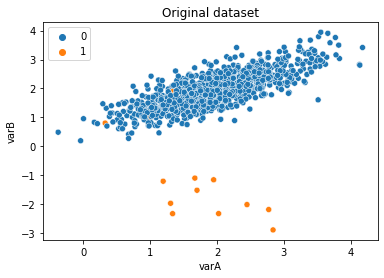

In [7]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

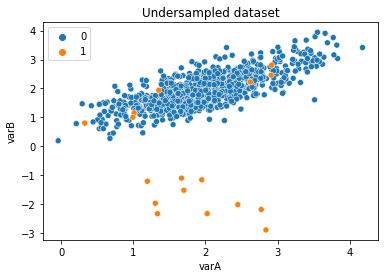

In [8]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset')
plt.show()

Note how some yellow dots can now be seen clearer, as their neighbouring observations from the other class were removed from the data set.

In [9]:
# let's find the observations that were removed from the 
# original dataset

# the attribute sample_indices_ indicates the samples retained
# so the remainaing samples are the ones removed

removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index ]

len(removed_obs), np.mean(removed_obs)

(1000, 0.113)

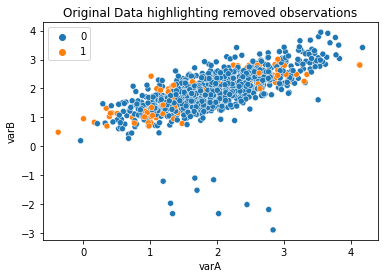

In [10]:
# plot original data and highlight observations
# that were removed

sns.scatterplot(
        data=X, x="varA", y="varB", hue=removed_obs
    )

plt.title('Original Data highlighting removed observations')
plt.show()

You can see that the removed observations are those around the minority class. 

### Partially separated classes

Let's repeat the same exercise in data where the classes are not so clearly separated. 

In [11]:
# create data
X, y = make_data(sep=0)

# set up instance hardness threshold

iht = InstanceHardnessThreshold(
    # now we try a logistic regression classifier
    estimator=LogisticRegression(random_state=0),
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold

X_resampled, y_resampled = iht.fit_resample(X, y)

In [12]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [13]:
# undersampled data

X_resampled.shape, y_resampled.shape

((34, 2), (34,))

In [14]:
y.value_counts()

0    983
1     17
dtype: int64

As the classes are not so clearly distinguished, more samples were removed from the dataset.

**HOMEWORK**

Go ahead and compare the results of instance threshold using Random Forests for this example. You can also try other machine learning models.

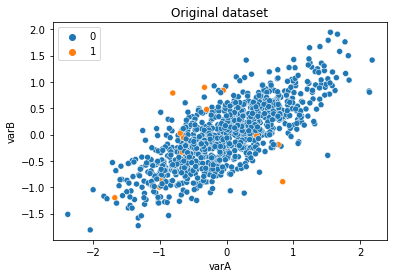

In [15]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

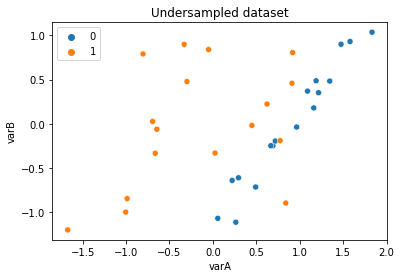

In [16]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()

Most observations where removed. 

In [17]:
# find removed observations

removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index ]

len(removed_obs), np.mean(removed_obs)

(1000, 0.966)

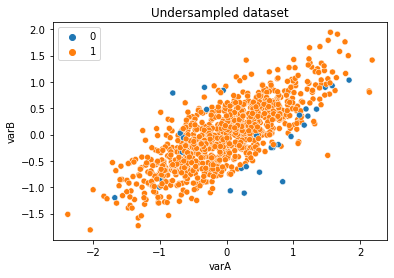

In [18]:
# plot original data highlighing removed observations

sns.scatterplot(
        data=X, x="varA", y="varB", hue=removed_obs
    )

plt.title('Undersampled dataset')
plt.show()

## Instance Hardness Threshold

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [20]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('../kdd2004.csv').sample(10000)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
51100,33.11,34.00,-0.56,-1.0,58.5,1505.3,-1.80,-1.19,-12.5,-44.5,...,2709.6,-2.86,0.86,7.0,-45.0,302.1,-0.11,-0.07,-1.22,-1
6834,64.58,24.49,-0.67,-64.0,24.0,1446.6,-0.26,0.85,-29.5,-74.0,...,1779.6,-0.82,1.91,-3.0,-48.0,610.4,-0.98,0.20,0.15,-1
88620,57.69,27.47,-0.25,-16.5,-27.5,1053.4,0.25,-0.45,-4.0,-75.5,...,935.5,-0.67,-2.68,-16.0,-33.0,172.5,1.61,0.20,-0.24,-1
103348,66.06,27.10,1.33,40.0,-40.5,1923.7,-0.20,2.22,39.5,-118.5,...,2031.2,0.04,0.82,12.0,-59.0,857.3,-0.79,0.45,0.04,-1
11587,55.78,28.57,0.11,-10.5,3.0,1070.2,0.34,-1.06,-0.5,-54.5,...,847.1,0.97,-1.77,3.0,-39.0,239.7,1.28,0.20,0.08,-1


In [21]:
# imbalanced target

data.target.value_counts() / len(data)

-1    0.9898
 1    0.0102
Name: target, dtype: float64

In [22]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

In [23]:
# instance hardness threshold using logistic regression

iht_logit = InstanceHardnessThreshold(
    estimator=LogisticRegression(random_state=0),
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold

X_logit, y_logit = iht_logit.fit_resample(X_train, y_train)

In [24]:
# instance hardness threshold using random forests

iht_rf = InstanceHardnessThreshold(
    estimator=RandomForestClassifier(n_estimators=100, random_state=0),
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold


X_rf, y_rf = iht_rf.fit_resample(X_train, y_train)

In [25]:
# compare shapes

X_train.shape, X_logit.shape, X_rf.shape

((7000, 74), (142, 74), (150, 74))

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [26]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [27]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9928632264070787
Test set
Random Forests roc-auc: 0.9952846076119906


In [28]:
# evaluate performance of algorithm built
# using iht and logit

run_randomForests(X_logit,
                  X_test,
                  y_logit,
                  y_test)

Train set
Random Forests roc-auc: 0.9998016266613767
Test set
Random Forests roc-auc: 0.9932745901194059


In [29]:
# evaluate performance of algorithm built
# using iht and random forests

run_randomForests(X_rf,
                  X_test,
                  y_rf,
                  y_test)

Train set
Random Forests roc-auc: 1.0
Test set
Random Forests roc-auc: 0.9771401253816318


We see that the hard instance threshold applied utilising predictions from random forests returns a better performing model. The Instance Hardness Threshold using one using Logistic regression did not improve performance, most likely because samples are not linearly related to the target.